In [510]:
%matplotlib inline

import ROOT, sys, os
from ROOT import std

from larcv import larcv
from larlite import larlite as ll
from larlite import larutil as lu

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib.patches as patches

from ROOT import geo2d,cv
from ROOT.cv import Point_ as Vector
DTYPE='float'

import root_numpy as rn
import pandas as pd

geoh=lu.GeometryHelper.GetME()
geo=lu.Geometry.GetME()
larp=lu.LArProperties.GetME()
pygeo = geo2d.PyDraw()

matplotlib.rcParams['font.size']=20
matplotlib.rcParams['font.family']='serif'

In [511]:
reco_event_df = pd.DataFrame(rn.root2rec("../reco_ana.root",treename='EventTree'))
reco_vtx3d_df = pd.DataFrame(rn.root2rec("../reco_ana.root",treename='Vtx3DTree'))
mc_df   = pd.DataFrame(rn.root2rec("../mc_ana.root",treename='mctree'))

/Library/Python/2.7/site-packages/root_numpy/_tree.py:248: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)
/Library/Python/2.7/site-packages/root_numpy/_tree.py:248: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)
/Library/Python/2.7/site-packages/root_numpy/_tree.py:248: DeprecationWarning: root2rec is deprecated and will be removed in 5.0.0. Instead use root2array(...).view(np.recarray)
  DeprecationWarning)


In [512]:
#Calculating the signal denomenator...
pdg2mass={}
pdg2mass[13]  = 105
pdg2mass[2212]= 938
pdg2mass[2112]= 939.5
pdg2mass[11]  = 0#0.5
pdg2mass[311] = 497.65
def mass(pdg):
    return pdg2mass[pdg]
mass_vec=np.vectorize(mass)

mc_wdf=mc_df.copy()
print mc_wdf.index.size
mc_wdf=mc_wdf.query('energyInit > 100 & energyInit < 500')
print mc_wdf.index.size
mc_wdf=mc_wdf[mc_wdf.daughterPdg_v.apply(lambda x : x.size>=2)]
print mc_wdf.index.size

def containment(row):
    pdg_v   = row['daughterPdg_v']
    einit_v = row['daughterEnergyInit_v']
    edep_v  = row['daughterEnergyDep_v']
    
    eisub_v=einit_v-mass_vec(pdg_v)
  
    init_sum = eisub_v.sum()
    dep_sum  = edep_v.sum()
    
    proton_v=eisub_v[np.where(pdg_v==2212)[0]]
    
    if(np.where(proton_v>80)[0].size>0): pass
    else: return False;
        
    if dep_sum / init_sum < 0.9: return False;

    return True;
    
mc_wdf=mc_wdf[mc_wdf.apply(containment,axis=1)]
print mc_wdf.index.size
mc_wdf_idx = mc_wdf.index

917
551
224
112


In [513]:
#Calculating the efficiency numerator
#reco_df_copy will have our analysis cuts
reco_event_wdf = reco_event_df.ix[mc_wdf_idx].copy()

cuts_v=[]
cuts_v.append('n_vtx3d>0')

for cut in cuts_v:
    reco_event_wdf = reco_event_wdf.query(cut)

print reco_event_wdf.index.size

#filter vertices from, only care about the events that have
#vertex estimated from 3 planes
#reco_wdf = reco_wdf[reco_wdf['num_planes_v'].apply(lambda x : np.where(x==3)[0].size)>0]

print reco_event_wdf.index.size

#cut on the pixel frac
#pxfrac=0.9
#def pixels(x):
#    y=np.hstack(x)
#    return np.where(y>pxfrac)[0].size

#reco_wdf=reco_wdf[reco_wdf['num_pixel_frac_vv'].apply(pixels) > 0]

96
96


In [514]:
efficiency = 96/112.
print efficiency

0.857142857143


In [515]:

#join the event and vtx3d dataframes
#the event data frame has been filtered by number of 3D vertex
a=reco_event_wdf.set_index(['run','subrun','event'])
b=reco_vtx3d_df.set_index(['run','subrun','event'])

#get the vtx3d entries that are in events with 3D vertex
reco_df=a.join(b)

#group the event,run,and subrun into groups (1 group == 1 event now...)
event_group=reco_df.groupby(reco_df.index)

#for each group look at the num pixel frac, return the index in the group that gives highest SUM! -- this is vtx id
g=event_group['num_pixel_frac_v'].apply(lambda x : np.argmax(np.row_stack(x.values).sum(axis=1)))

top_idx=np.concatenate((np.vstack(g.index.values),g.values.reshape(g.values.shape[0],1)),axis=1)

#set the vertex ID on the index, this allows us to selection the correct r/s/e/vtxid
reco_df=reco_df.set_index('vtx3d_id',append=True,drop=True)

#get only the index if the highest pixel fraction
reco_df=reco_df.ix[pd.Index(top_idx).astype(np.object)]

#chosen reco dataframe (after analysis cuts)
reco_cdf = reco_df.reset_index(['vtx3d_id'])

In [516]:
mc_cdf=mc_wdf.set_index(['run','subrun','event']).ix[reco_cdf.index]

dw_v=mc_cdf.vtx2d_w.values  - reco_cdf.circle_vtx_y_v.values
dt_v=mc_cdf.vtx2d_t.values  - reco_cdf.circle_vtx_x_v.values


dw_v=np.vstack(dw_v)
dt_v=np.vstack(dt_v)


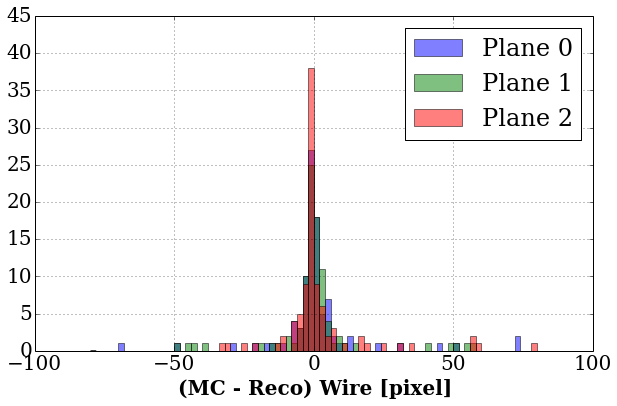

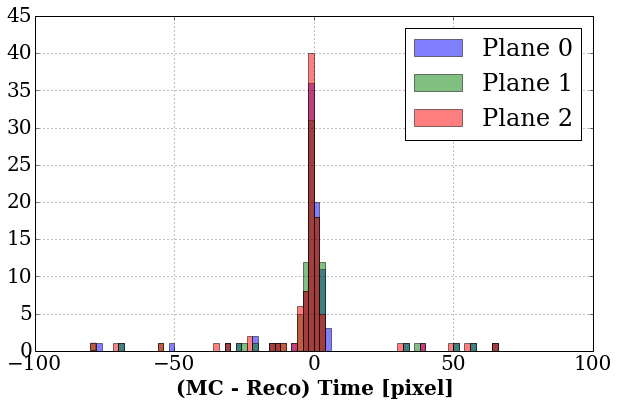

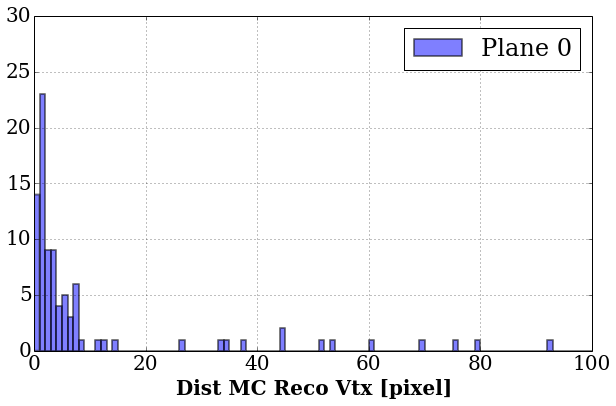

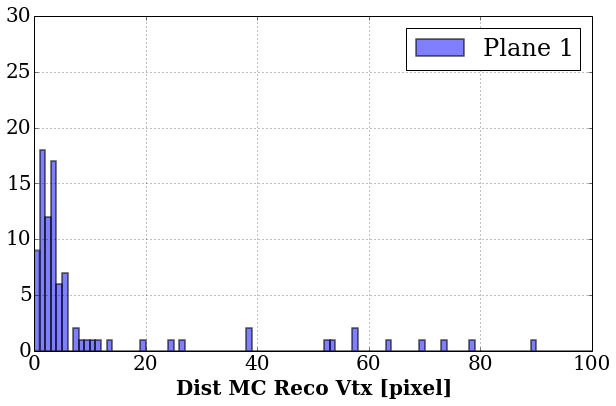

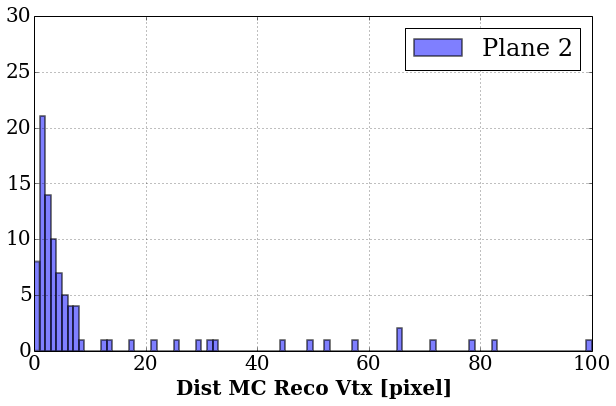

In [517]:
#2d resolution plots 

fig,ax=plt.subplots(figsize=(10,6))
for i in xrange(3):
    ax.hist(dw_v[:,i],
            label='Plane {}'.format(i),
            bins=np.arange(-80,80+2,2),
            alpha=0.5)
ax.set_xlabel("(MC - Reco) Wire [pixel]",fontweight='bold')
ax.set_ylim(0,45)
ax.set_xlim(-100,100)
ax.legend()
plt.grid()
plt.show()

fig,ax=plt.subplots(figsize=(10,6))
for i in xrange(3):
    ax.hist(dt_v[:,i],
            label='Plane {}'.format(i),
            bins=np.arange(-80,80+2,2),
            alpha=0.5)
ax.set_xlabel("(MC - Reco) Time [pixel]",fontweight='bold')
ax.set_ylim(0,45)
ax.set_xlim(-100,100)
ax.legend()
plt.grid()
plt.show()


for i in xrange(3):
    fig,ax=plt.subplots(figsize=(10,6))
    ax.hist(np.sqrt(np.power(dw_v[:,i],2)+np.power(dt_v[:,i],2)),
            label='Plane {}'.format(i),
            bins=np.arange(0,100+1,1),
            alpha=0.5,lw=2)
    ax.set_xlabel("Dist MC Reco Vtx [pixel]",fontweight='bold')
    ax.set_ylim(0,30)
    ax.set_xlim(0,100)
    ax.legend()
    plt.grid()
    plt.show()

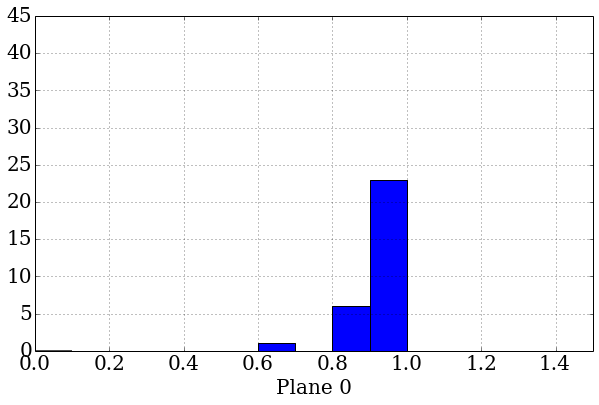

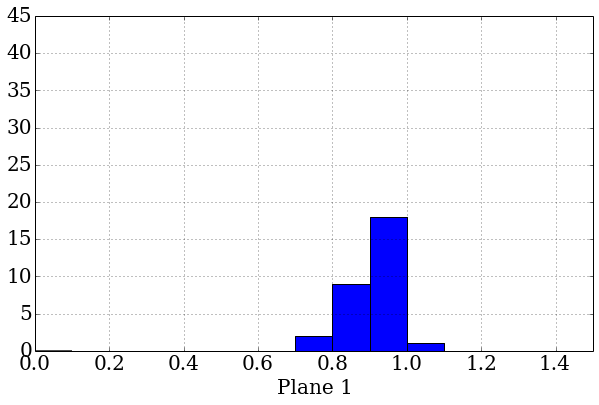

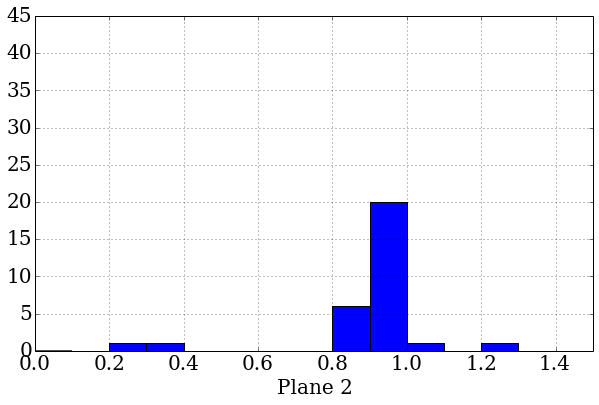

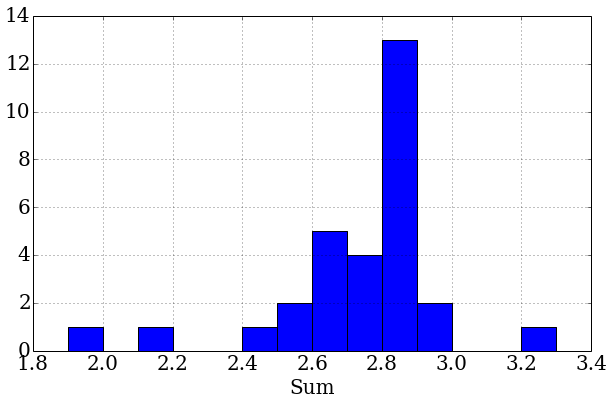

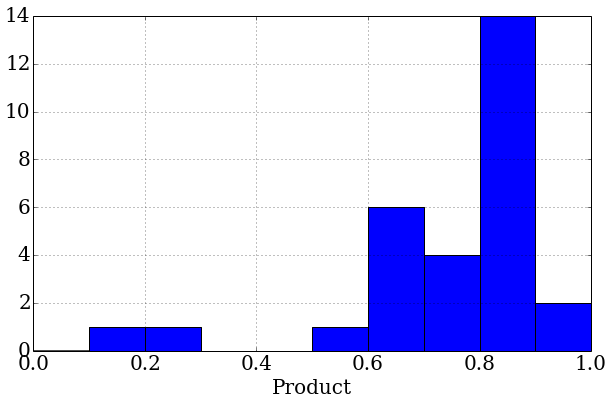

In [497]:
#num_pixel_frac check
p_=reco_cdf.num_pixel_frac_v
p_=np.vstack(p_)
for i in xrange(3):
    fig,ax=plt.subplots(figsize=(10,6))
    ax.hist(p_[:,i],bins=np.arange(0,1+0.6,0.1))
    ax.set_xlabel("Plane {}".format(i))
    ax.set_ylim(0,45)
    ax.set_xlim(0,1.5)
    plt.grid()
    plt.show()

fig,ax=plt.subplots(figsize=(10,6))
ax.hist(p_.sum(axis=1),bins=np.arange(0,4+0.1,0.1))
ax.set_xlabel("Sum")
plt.grid()
plt.show()

fig,ax=plt.subplots(figsize=(10,6))
ppp=p_[:,0]*p_[:,1]*p_[:,2]
ax.hist(ppp,bins=np.arange(0,1+0.6,0.1))
ax.set_xlim(0,1.0)
ax.set_xlabel("Product")
plt.grid()
plt.show()

In [506]:
#chose the 3D vertex with highest num_pix_frac
def hi_pix_idx(row):
    x_v = row['vtx3d_x_v']
    y_v = row['vtx3d_y_v']
    z_v = row['vtx3d_z_v']
    num_pix_frac_vv = row['num_pixel_frac_vv']
    idx=np.argmax(np.sum(np.vstack(num_pix_frac_vv),axis=1))
    return [x_v[idx],y_v[idx],z_v[idx]]

vtx_x=reco_cdf.vtx3d_x.values
vtx_y=reco_cdf.vtx3d_y.values
vtx_z=reco_cdf.vtx3d_z.values

vtx=np.vstack([vtx_x,vtx_y,vtx_z]).T

In [507]:
dvtx=vtx-mc_cdf[['parentX','parentY','parentZ']].values

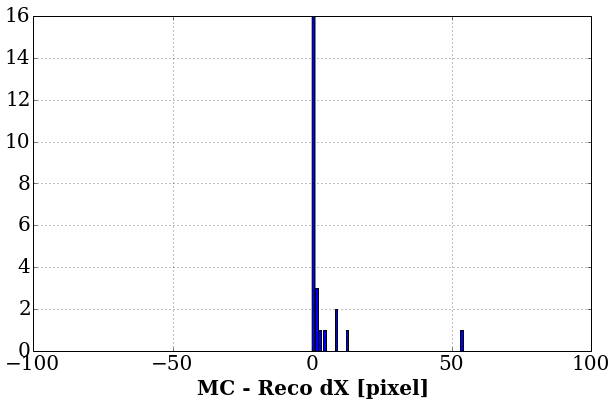

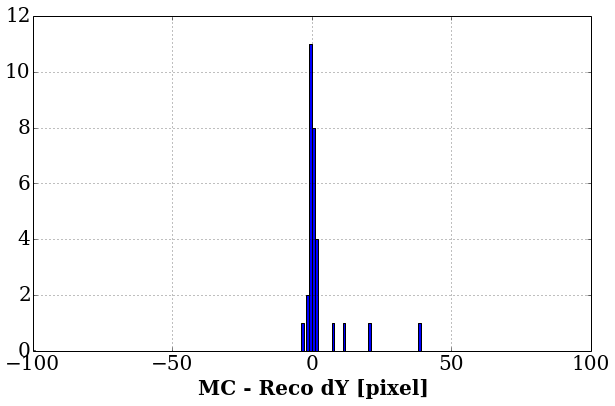

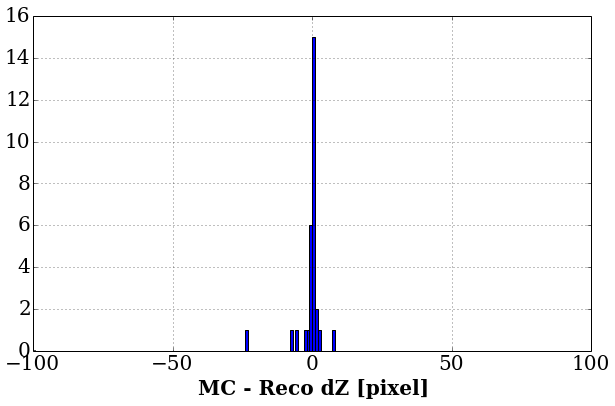

In [509]:
fig,ax=plt.subplots(figsize=(10,6))
ax.hist(dvtx[:,0],bins=np.arange(0,100,1))
ax.set_xlabel('MC - Reco dX [pixel]',fontweight='bold')
ax.set_xlim(-100,100)
plt.grid()
plt.show()

fig,ax=plt.subplots(figsize=(10,6))
ax.hist(dvtx[:,1],bins=np.arange(-100,100,1))
ax.set_xlim(-100,100)
plt.grid()
ax.set_xlabel('MC - Reco dY [pixel]',fontweight='bold')
plt.show()

fig,ax=plt.subplots(figsize=(10,6))
ax.hist(dvtx[:,2],bins=np.arange(-100,100,1))
ax.set_xlim(-100,100)
plt.grid()
ax.set_xlabel('MC - Reco dZ [pixel]',fontweight='bold')
plt.show()